In [ ]:
pip install yahooquery

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 24.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.26.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.1 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.1 which is incompatible.


<ipython-input-4-d42da59746ef>:185: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


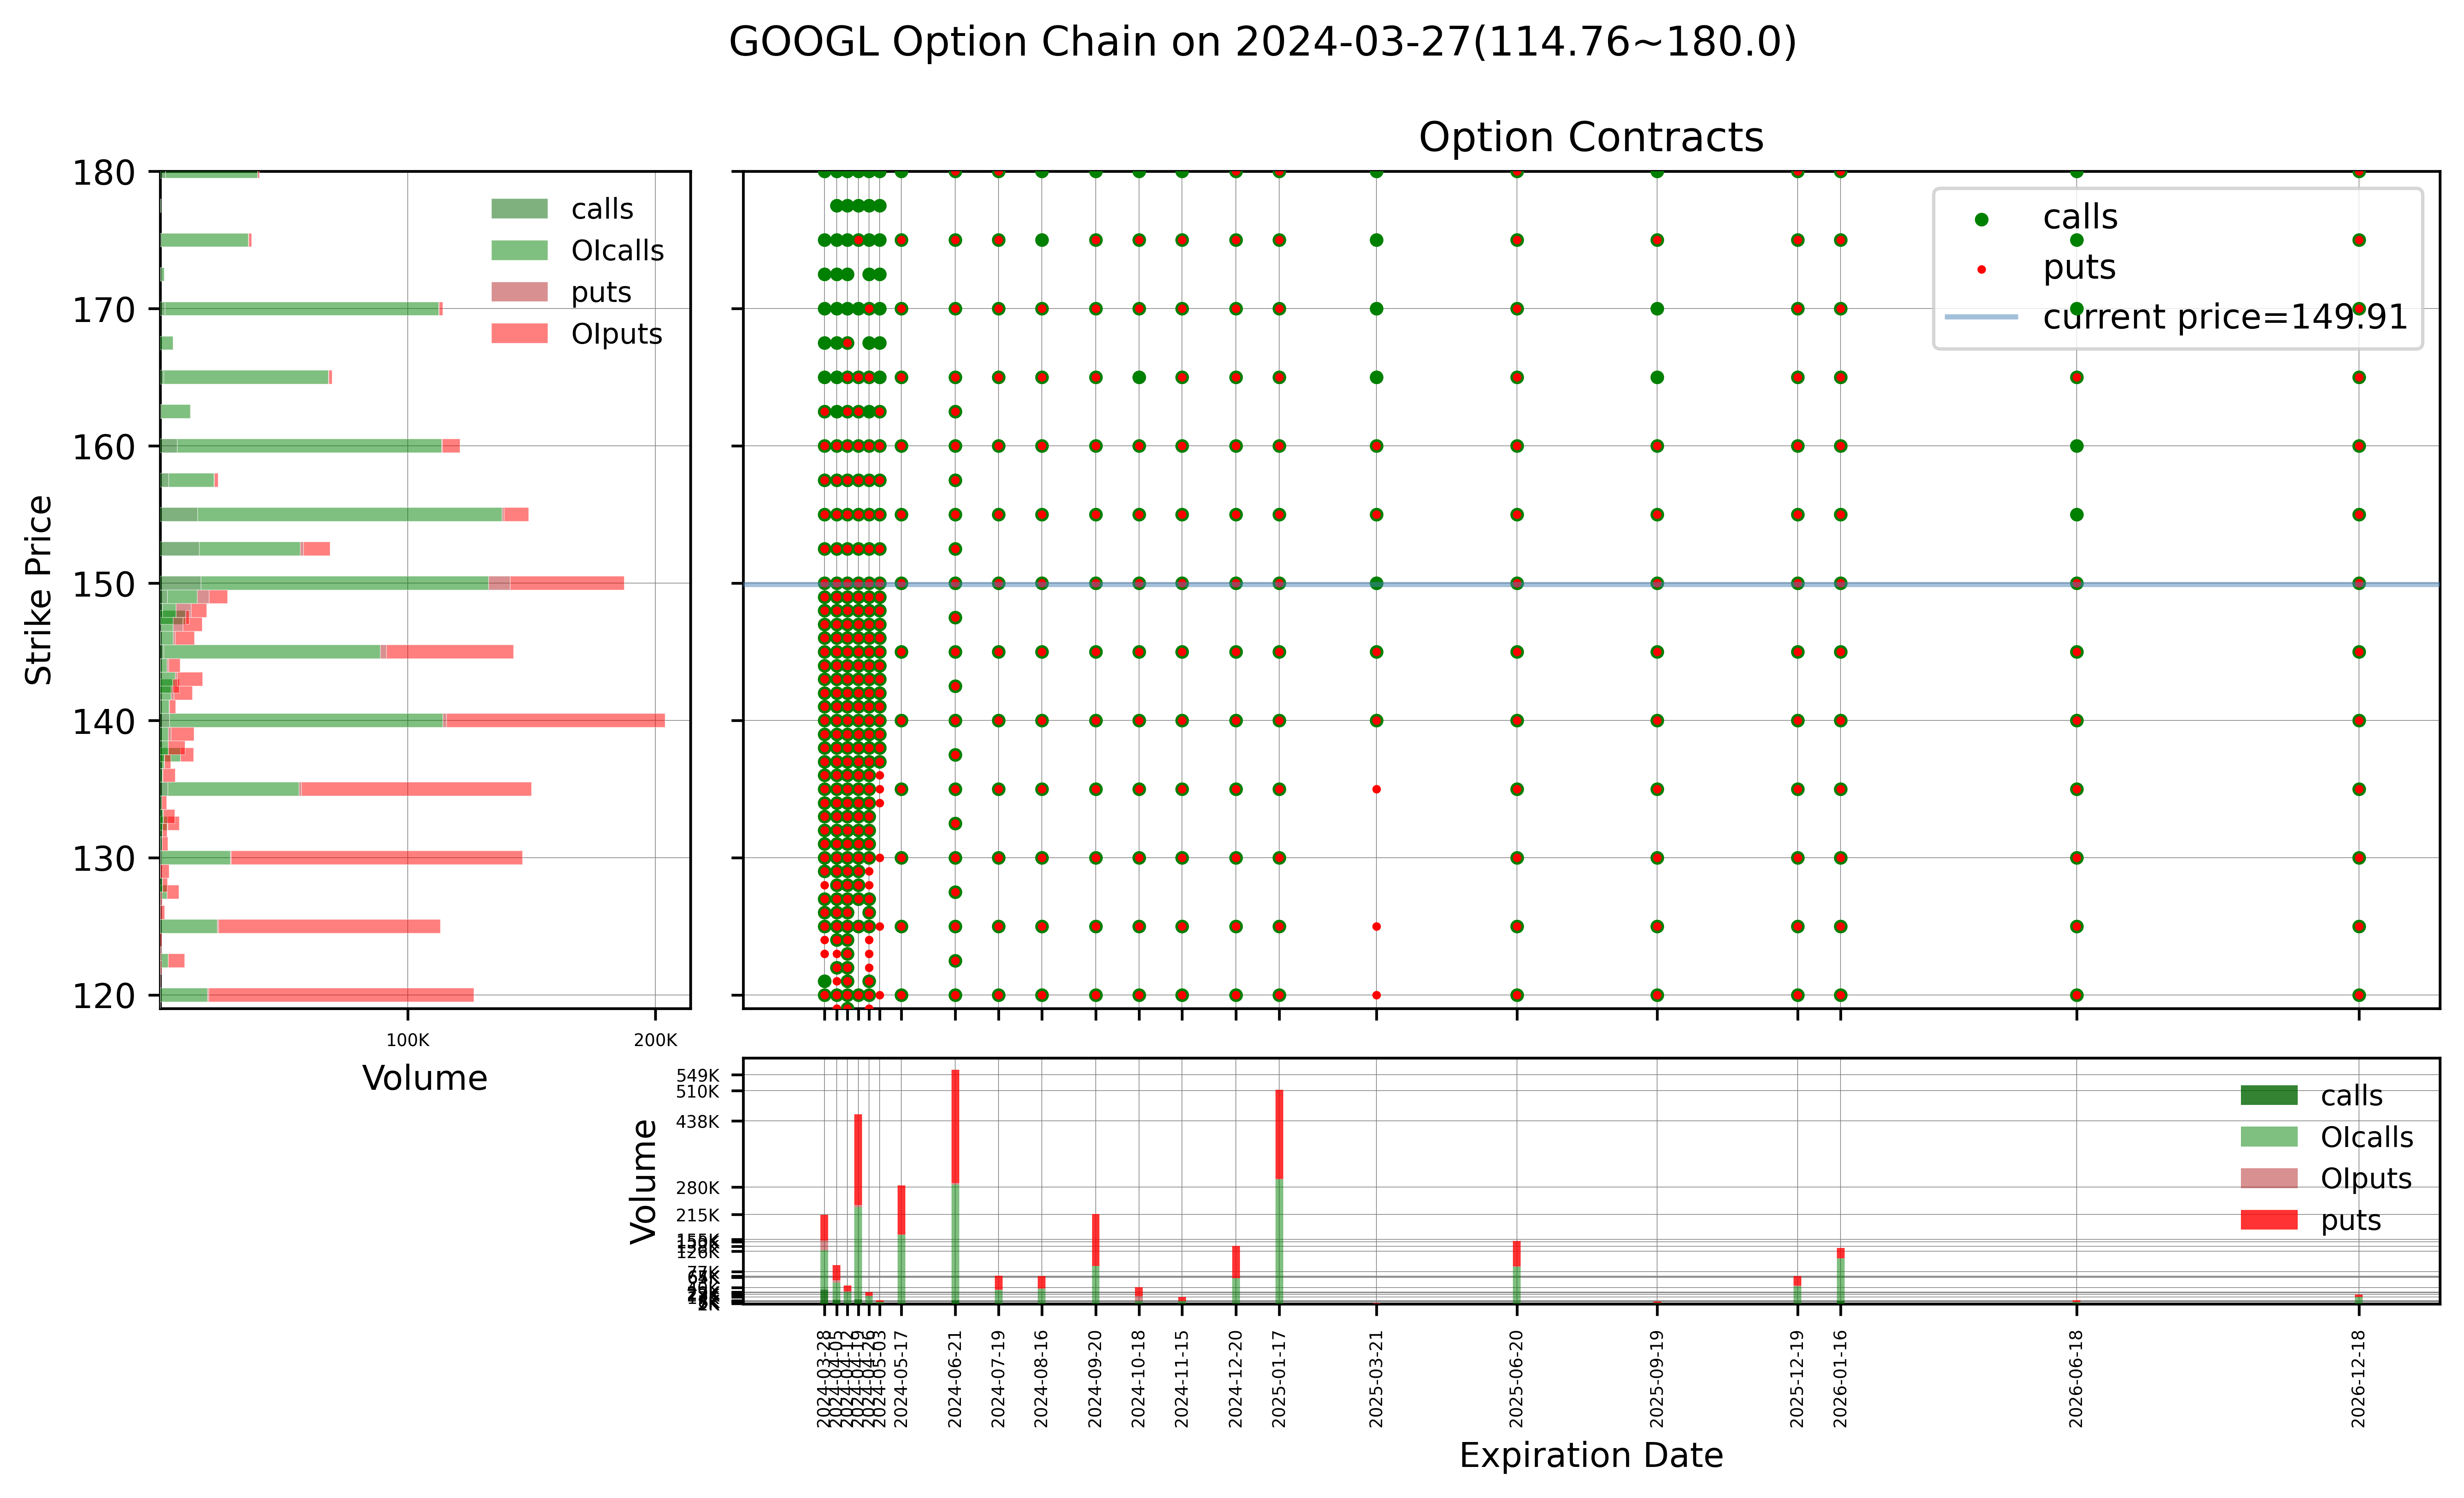

In [ ]:
import numpy as np
import math
import datetime as dt
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter

from yahooquery import Ticker # pip install yahooquery


today_str=dt.datetime.today().strftime('%Y-%m-%d')

# some handy tools for formatting the chart

def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x*1e-3)

def round_and_group(data,base=5):
    df = data[['strike', 'volume']].copy()
    #Round to nearest X
    df['strike'] = df['strike'].apply(lambda x: custom_round(x, base=base))
    # Remove the date index
    df = df.set_index('strike')
    df = df.groupby(['strike']).sum()

    return df

def remove_duplicate_label(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))



def plot_option_chain(symbol, df, stockTicker):

    IS_STOCK=True # just to keep track if the symbol is stock or not as stock as some target price information

    stock_data=stockTicker.financial_data[symbol] # get some price info from Ticker

    if "No fundamentals" in stock_data : #it is not a stock maybe is an index or ETF?
        stock_data=stockTicker.price[symbol]
        currentPrice=stock_data['regularMarketPreviousClose']
    else:
        try:
            currentPrice=stock_data['currentPrice']
            targetHighPrice=stock_data['targetHighPrice']
            targetLowPrice=stock_data['targetLowPrice']
        except:
            IS_STOCK=False

    if df.empty:
        print (symbol,' has no Option Chain, program abort.')
        return None

    # =============================================================================
    #     Prepare the plot data
    # =============================================================================

    # make a pivot table per strike price
    pivot_df = pd.pivot_table(df,index=['strike'],
                              columns=['optionType'],
                              values= ['volume', 'openInterest'],
                              aggfunc='sum')


    # =============================================================================
    #     Now Let's plot the chart
    # =============================================================================

    fig = plt.figure(figsize=(12, 6),dpi=600)

    # prepare the subplot grid
    grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.1)

    main_ax = fig.add_subplot(grid[:-1, 1:])#,projection='3d')
    left_ax = fig.add_subplot(grid[:-1, 0],  sharey=main_ax)#xticklabels=[],
    bottom_ax = fig.add_subplot(grid[-1, 1:], sharex=main_ax)#yticklabels=[],

    main_ax.grid(True, color='grey',linewidth=0.2)
    left_ax.grid(True, color='grey',linewidth=0.2)
    bottom_ax.grid(True, color='grey',linewidth=0.2)

    # =============================================================================
    #     # Main chart
    # =============================================================================
    df_calls_at_strike=df[['openInterest','expiration','strike']].loc[(df['optionType']=='calls')  & (df['openInterest']>0)]
    df_puts_at_strike=df[['openInterest','expiration','strike']].loc[(df['optionType']=='puts')  & (df['openInterest']>0)]

    main_ax.scatter(df_calls_at_strike['expiration'], df_calls_at_strike['strike'], alpha=1, s=9, color='green', marker='o', label='calls',zorder=100)
    main_ax.scatter(df_puts_at_strike['expiration'], df_puts_at_strike['strike'], alpha=1, s=9,color='red', marker='.', label='puts',zorder=100)
    main_ax.axhline(currentPrice,color='steelblue',label='current price='+str(currentPrice),linewidth=1.5,alpha=0.5,zorder=120)

    # =============================================================================
    #     # Left chart
    # =============================================================================

    # adjust bar width based on price chart range
    if IS_STOCK:
        bar_width=round(((targetHighPrice-targetLowPrice) / len(pivot_df.loc[(pivot_df.index>targetLowPrice) & (pivot_df.index<targetHighPrice)]))*0.8,1)
    else:
        bar_width=2

    left_ax.barh(pivot_df.index, pivot_df[('volume','calls')], color='darkgreen', alpha=0.5, label='calls', height=bar_width, edgecolor = "white",linewidth=0.2,zorder=100)
    left_ax.barh(pivot_df.index, pivot_df[('openInterest','calls')], color='green', alpha=0.5, left=pivot_df[('volume','calls')],label='OIcalls', height=bar_width, edgecolor = "white",linewidth=0.2,zorder=100)
    left_ax.barh(pivot_df.index, pivot_df[('volume','puts')], color='firebrick', alpha=0.5, left=pivot_df[('volume','calls')]+pivot_df[('openInterest','calls')], label='puts', height=bar_width,edgecolor = "white", linewidth=0.2,zorder=100)
    left_ax.barh(pivot_df.index, pivot_df[('openInterest','puts')], color='red', alpha=0.5, left=pivot_df[('volume','calls')]+pivot_df[('openInterest','calls')]+pivot_df[('volume','puts')],  label='OIputs', height=bar_width,edgecolor = "white",linewidth=0.2,zorder=100)

    # try to focus on +/- 20% of price range only,
    # YOU CAN REMOVE THIS LINE IF YOU WANT TO SEE ALL OPTIONS STRIKE
    if IS_STOCK:
        left_ax.set_ylim(math.floor(currentPrice*0.8),math.ceil(currentPrice*1.2))

    # =============================================================================
    #     # Bottom chart
    # =============================================================================

    df_calls_at_volume=df[['expiration','openInterest','volume']].loc[(df['optionType']=='calls')]
    df_puts_at_volume=df[['expiration','openInterest','volume']].loc[(df['optionType']=='puts')]

    df_calls_at_volume=df_calls_at_volume.groupby('expiration').sum()
    df_puts_at_volume=df_puts_at_volume.groupby('expiration').sum()

    bottom_ax.bar(df_calls_at_volume.index, df_calls_at_volume['volume'], width=5, alpha=0.8, color='darkgreen', label='calls', zorder=100)
    bottom_ax.bar(df_calls_at_volume.index, df_calls_at_volume['openInterest'], width=5, alpha=0.5, color='green', bottom=df_calls_at_volume['volume'], label='OIcalls', zorder=100)
    bottom_ax.bar(df_puts_at_volume.index, df_puts_at_volume['volume'], width=5,  alpha=0.5, color='firebrick',bottom=df_calls_at_volume['volume']+df_calls_at_volume['openInterest'], label='OIputs', zorder=100)
    bottom_ax.bar(df_puts_at_volume.index, df_puts_at_volume['openInterest'], width=5,  alpha=0.8, color='red', bottom=df_calls_at_volume['volume']+df_calls_at_volume['openInterest']+df_puts_at_volume['volume'], label='puts', zorder=100)


    # =============================================================================
    # SET subplot TICKS for chart
    # =============================================================================


    main_ax.set_title('Option Contracts', fontsize=12)

    # Left ticks and labels
    formatter = FuncFormatter(thousands)
    left_ax.xaxis.set_major_formatter(formatter)
    left_ax.locator_params(axis="x", nbins=3)
    left_ax.tick_params(axis="x", labelsize=5)

    left_ax.set_ylabel('Strike Price', fontsize = 10)
    left_ax.set_xlabel('Volume', fontsize = 10)

    # Bottom ticks and labels
    new_ticks=df['expiration'].unique()
    bottom_ax.set_xticks(new_ticks)
    bottom_ax.set_xticklabels(new_ticks,rotation=90,fontsize=5)
    new_ticks=(df_calls_at_volume['openInterest']+df_puts_at_volume['openInterest']).sort_values(ascending=False)
    bottom_ax.set_yticks(new_ticks)
    bottom_ax.set_yticklabels(new_ticks,fontsize=5)

    bottom_ax.set_xlabel('Expiration Date', fontsize = 10)
    bottom_ax.set_ylabel('Volume', fontsize = 10)

    formatter = FuncFormatter(thousands)
    bottom_ax.yaxis.set_major_formatter(formatter)

    # Select which subplot axis to show or hide
    left_ax.get_xaxis().set_visible(True)
    left_ax.get_yaxis().set_visible(True)
    bottom_ax.get_xaxis().set_visible(True)
    bottom_ax.get_yaxis().set_visible(True)
    main_ax.tick_params(labelbottom=False, labelleft=False)

    # show legend per subplot
    main_ax.legend(labelcolor='black',fontsize='small', frameon=True, loc='lower right')
    left_ax.legend(labelcolor='black',fontsize='small', frameon=False, loc='upper right')
    bottom_ax.legend(labelcolor='black',fontsize='small', frameon=False, loc='upper right')
    remove_duplicate_label(main_ax)

    # Give it a title
    if IS_STOCK:
        plt.suptitle(symbol+' Option Chain on '+today_str+'('+str(targetLowPrice)+'~'+str(targetHighPrice)+')',fontsize=12)
    else:
        plt.suptitle(symbol+' Option Chain on '+today_str,fontsize=12)

    plt.rcParams['savefig.facecolor']='silver'
    plt.tight_layout()
    plt.show()
    return fig

def query_option_chain(ticker):

    df=pd.DataFrame()
    df=ticker.option_chain
    if df.empty:
        print ('Sorry, no option chain data returned.')
        return None
    df=df.reset_index().set_index('contractSymbol')

    # making sure all number columns are float and not treat as string
    for col in df.columns:
        try:
            df[col] = df[col].astype(float)
        except: # continue if column is not numeric whcih will throw an exception
            continue

    # cleansing expiration date by removing hh:mm:ss from datetime
    df['expiration'] = (pd.to_datetime(df['expiration'],utc=True)).dt.date


    return df


def option_chain(symbol):

    symbol= symbol.upper()
    ticker= Ticker(symbol) # get symbol ticker handle from yahooquery
    df = query_option_chain(ticker)
    fig = plot_option_chain(symbol,df,ticker)
    # let's save the chart in current directory
    fig.savefig('./'+symbol+'.jpg',dpi=300,bbox_inches='tight')




# Let's run it!
option_chain('GOOGL')